Examine the distribution of noise in production data.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.stattools import robust_kurtosis, robust_skewness
from scipy.stats import kstest, norm, laplace, logistic, gennorm

golden_ratio = (1 + np.sqrt(5)) / 2

In [24]:
# create function to calculate modified ARPS decline
def calc_modified_arps(qi=None, di=None, b=None, dmin=None, qab=None):
        """
        Calculate a modified ARPS decline with a terminal exponential 
        decline and an abandonment rate.
        
        Parameters:
        - qi: Initial production rate, bopd
        - di: Initial decline rate, effecitve annual
        - b: b-factor
        - dmin: Minimum decline rate, effective annual
        - r_abandon: Abandonment rate, bopd
        
        Returns:
        - Production rate at time t
        """
        t = np.arange(0, 365 * 100)
        D_tangent = ((1 - di) ** (-b) - 1) / b
        D_terminal = -1 * np.log(1 - dmin)
        q_terminal = qi * (D_terminal / D_tangent) ** (1 / b)
        t_terminal = ((qi / q_terminal) ** b - 1) / (b * D_tangent / 365)

        x = np.zeros(len(t))
        mask = t < t_terminal
        x[mask] = qi * (1 + b * (D_tangent / 365) * t[mask]) ** (-1 / b)
        x[~mask] = q_terminal * np.exp(-1 * (D_terminal / 365) * (t[~mask] - t_terminal))
        x[x < qab] = 0

        return x

In [48]:
# load the data into a df
prod = pd.read_csv(r'DAILY_PRODUCTION.csv')
prod['D_DATE'] = pd.to_datetime(prod['D_DATE'])
prod['ON'] = np.where(prod['OIL'] > 0, 1, 0)
prod['DAYS_ON'] = prod.groupby('WELL_NAME')['ON'].cumsum()
prod = prod[prod['ON'] > 0].copy()
prod['PCT_CHANGE'] = (prod['OIL'] - prod['OIL'].shift(1)) / prod['OIL'].shift(1) * 100

In [26]:
prod.head()

,PROPNUM,WELL_NAME,D_DATE,OIL,GAS,GAS_SALES,WATER,ON,DAYS_ON,PCT_CHANGE
1,N7RDMTXMLL,BUXBAUM 21-5-3H,2015-02-12,1468.23,539.00,NaN,3070.00,1,1,NaN
2,N7RDMTXMLL,BUXBAUM 21-5-3H,2015-02-13,987.63,660.00,NaN,2511.00,1,2,-32.733291
3,N7RDMTXMLL,BUXBAUM 21-5-3H,2015-02-14,1045.85,608.61,NaN,2161.69,1,3,5.894920
4,N7RDMTXMLL,BUXBAUM 21-5-3H,2015-02-15,1011.69,615.61,NaN,1841.76,1,4,-3.266243
5,N7RDMTXMLL,BUXBAUM 21-5-3H,2015-02-16,941.97,568.86,NaN,1608.48,1,5,-6.891439


# INVESTIGATE DAILY RATE

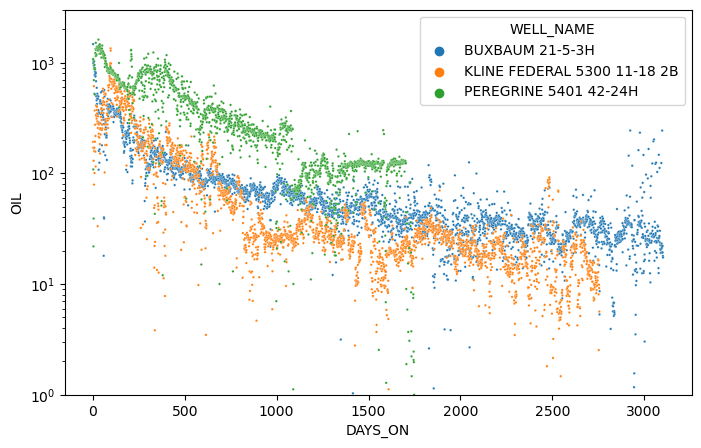

In [27]:
# plot the rate-time profile for each well
fig, ax = plt.subplots(figsize=(5 * golden_ratio, 5))
sns.scatterplot(x='DAYS_ON', y='OIL', hue='WELL_NAME', data=prod, ax=ax, s=3)
ax.set(yscale='log', ylim=(1,3000))
plt.show()

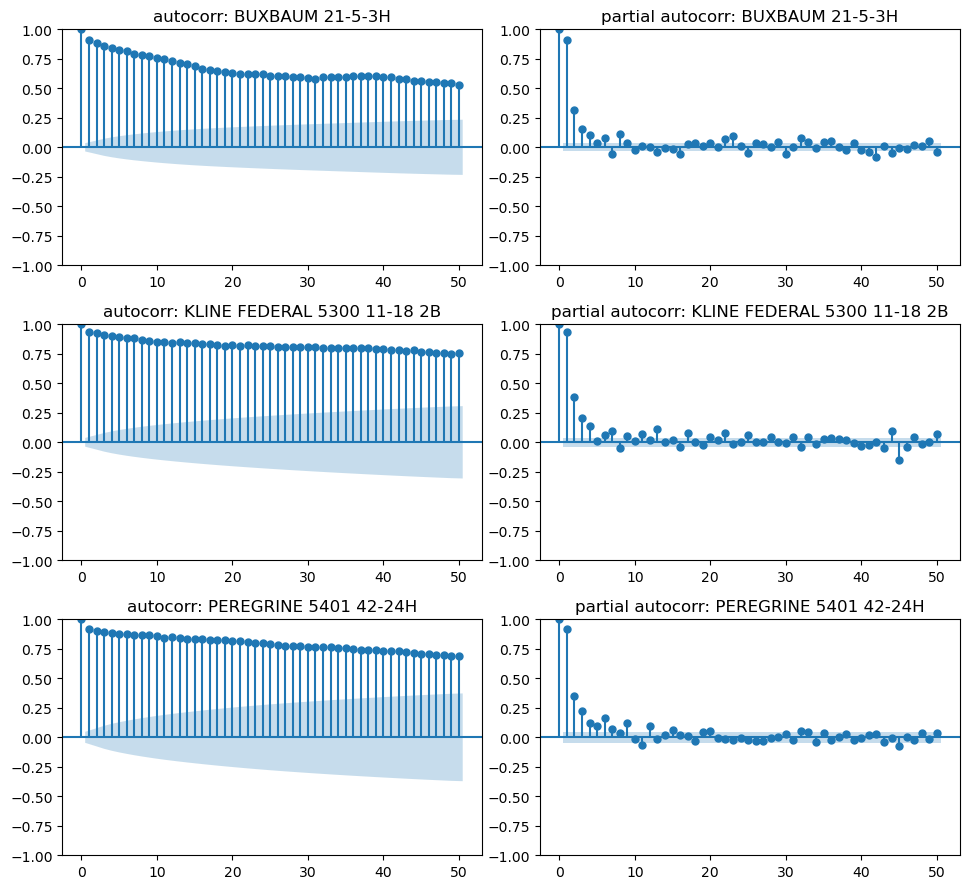

In [28]:
# plot the autcorr and partial autocorr for each well
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(2 * 3 * golden_ratio, 3 * 3))
for i, well in enumerate(prod['WELL_NAME'].unique()):
    ax = axs[i, 0]
    plot_acf(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['OIL'].dropna(), ax=ax, lags=50)
    ax.set(title='autocorr: ' + well)
    ax = axs[i, 1]
    plot_pacf(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['OIL'].dropna(), ax=ax, lags=50)
    ax.set(title='partial autocorr: ' + well)
plt.tight_layout(); plt.show()

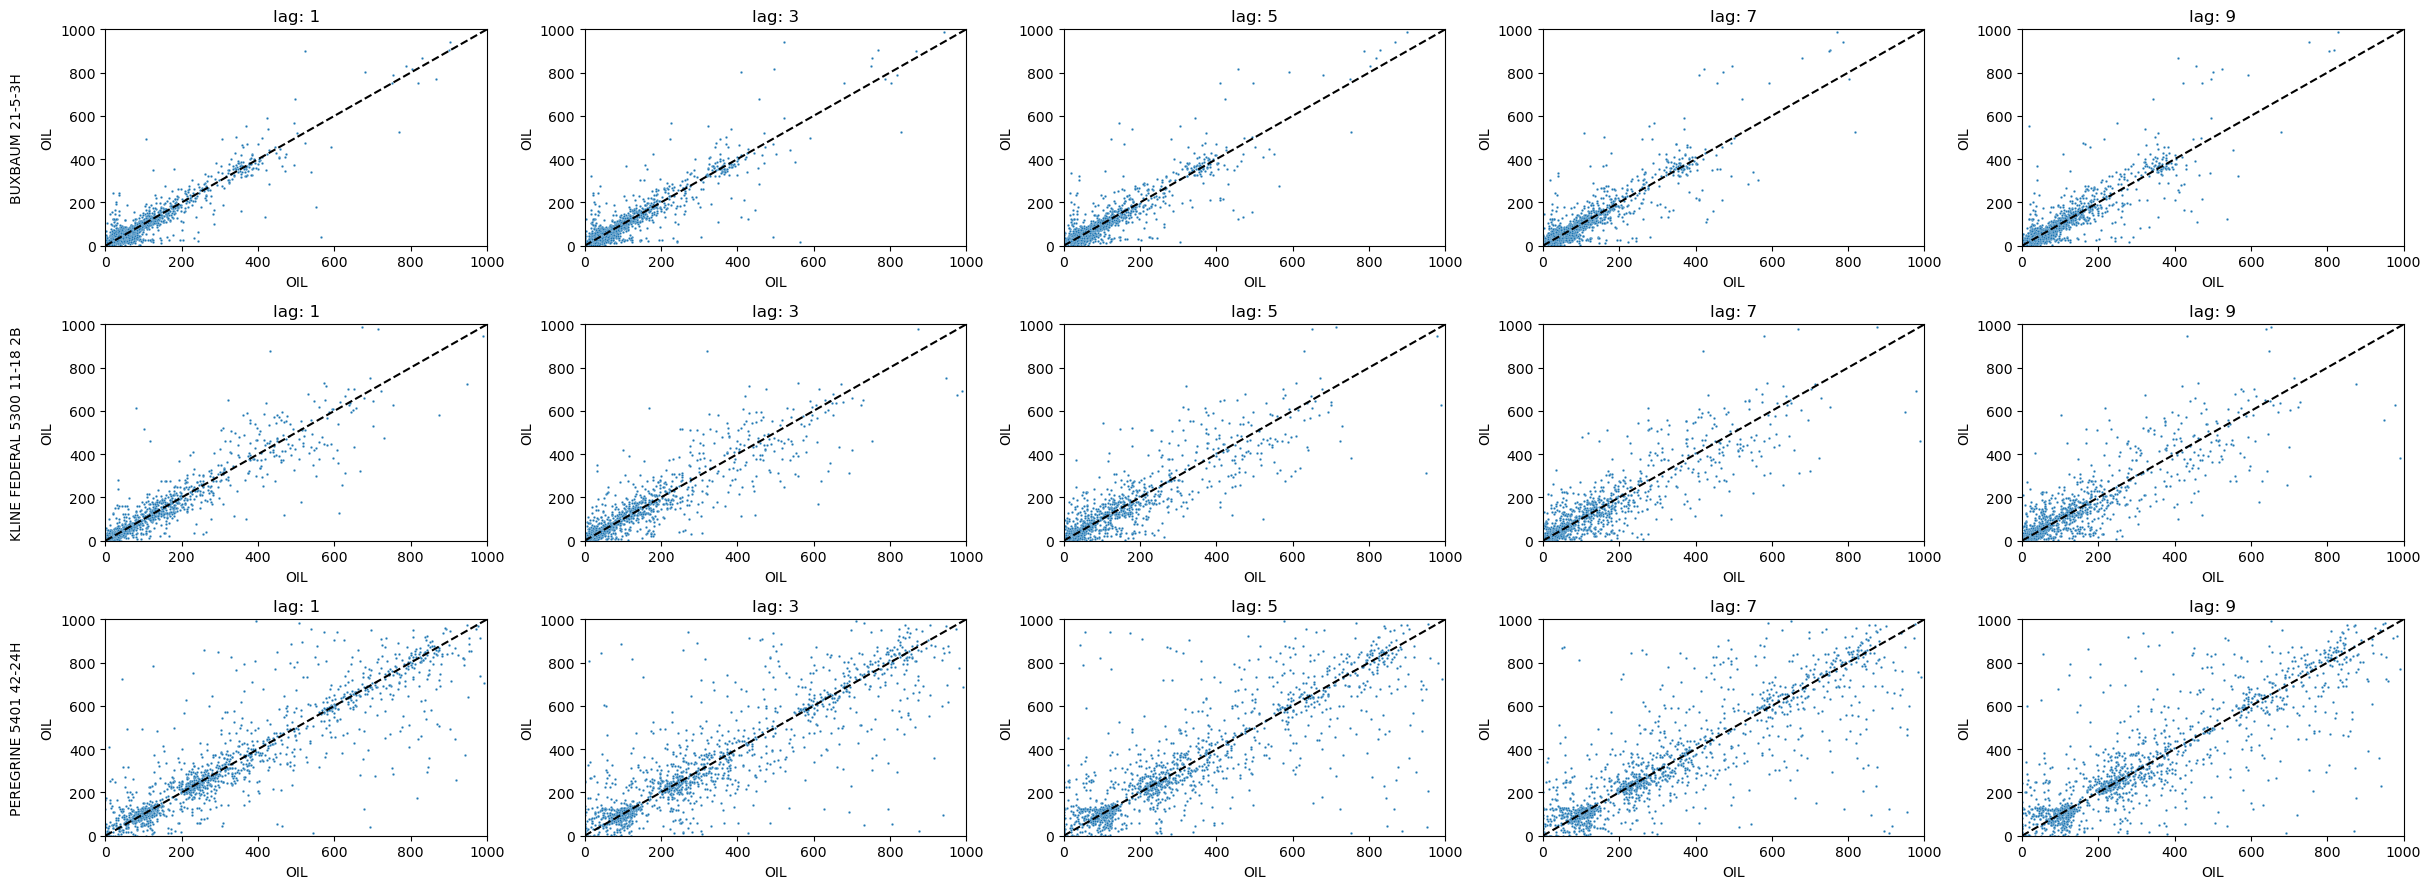

In [29]:
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(5 * 3 * golden_ratio, 3 * 3))
for i, well in enumerate(prod['WELL_NAME'].unique()):
    for j, lag in enumerate(range(1,10,2)):
        ax = axs[i, j]
        data = prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['OIL']
        shifted_data = data.shift(lag)
        sns.scatterplot(x=data, y=shifted_data, ax=ax, s=3)
        ax.plot([0, 1000], [0, 1000], color='black', linestyle='--')
        ax.set(xlim=(0,1000), ylim=(0,1000), title='lag: ' + str(lag))
        
    # Add well name as a label on the left side and rotate 180 degrees
    axs[i, 0].text(-0.25, 0.5, well, transform=axs[i, 0].transAxes, va='center', rotation=90)
    
plt.tight_layout(); plt.show()


There is autocorrelation in daily production data up to the 4th lag.

/Users/home/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3103
Model:                 ARIMA(4, 0, 1)   Log Likelihood              -14876.210
Date:                Sun, 28 Jan 2024   AIC                          29766.420
Time:                        13:24:39   BIC                          29808.700
Sample:                             0   HQIC                         29781.602
                               - 3103                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1446      0.185     -0.782      0.434      -0.507       0.218
ar.L1          0.9538      0.018     51.674      0.000       0.918       0.990
ar.L2         -0.0810      0.013     -6.472      0.0

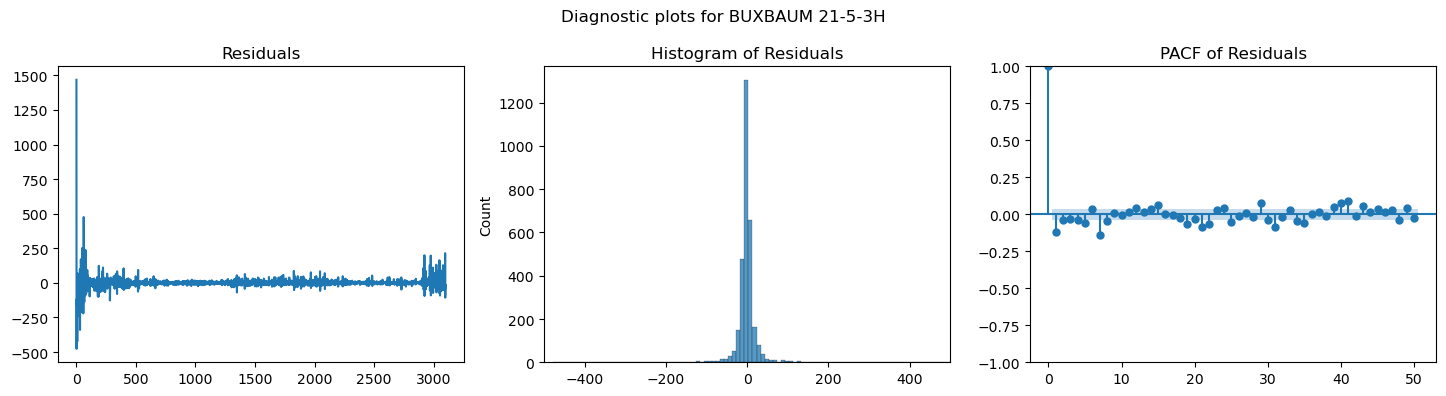

/Users/home/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2756
Model:                 ARIMA(4, 0, 1)   Log Likelihood              -14096.281
Date:                Sun, 28 Jan 2024   AIC                          28206.562
Time:                        13:24:40   BIC                          28248.013
Sample:                             0   HQIC                         28221.536
                               - 2756                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0048      0.179      0.027      0.979      -0.347       0.356
ar.L1          1.3735      0.007    187.492      0.000       1.359       1.388
ar.L2         -0.1949      0.009    -20.768      0.0

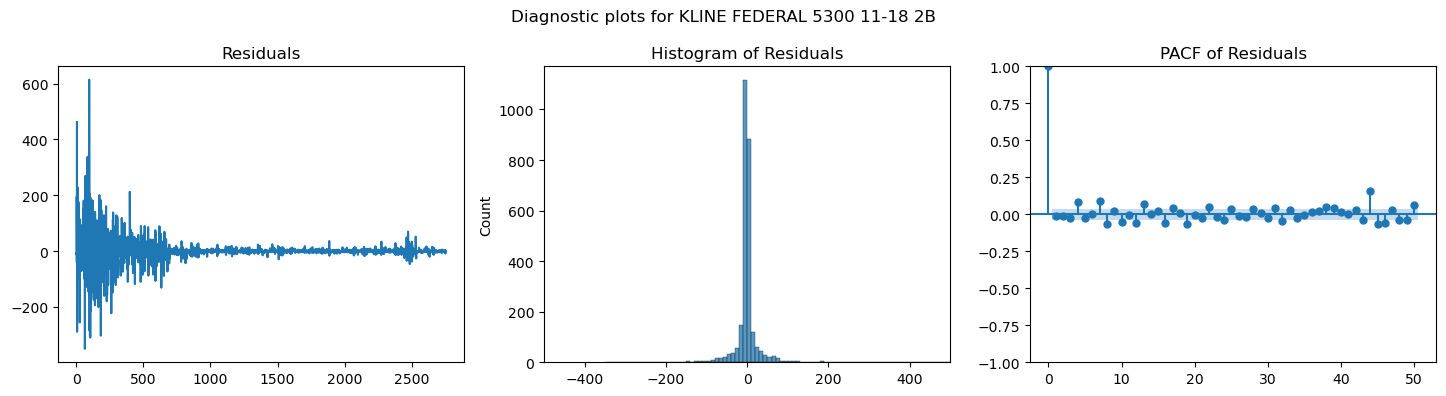

/Users/home/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1754
Model:                 ARIMA(4, 0, 1)   Log Likelihood              -10663.410
Date:                Sun, 28 Jan 2024   AIC                          21340.820
Time:                        13:24:41   BIC                          21379.108
Sample:                             0   HQIC                         21354.972
                               - 1754                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1983      0.420     -0.472      0.637      -1.022       0.625
ar.L1          1.3475      0.015     91.322      0.000       1.319       1.376
ar.L2         -0.2613      0.019    -14.054      0.0

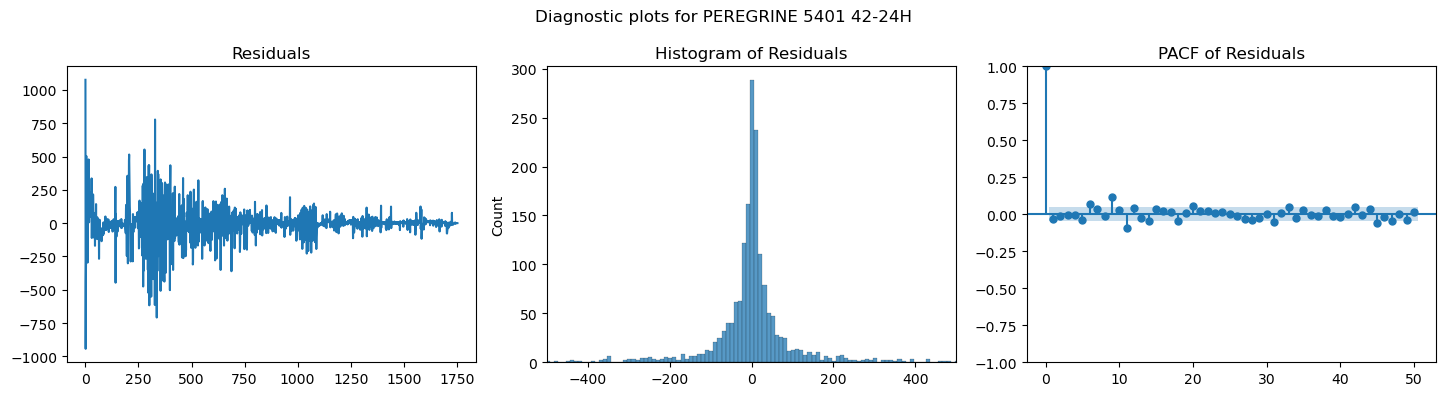

In [30]:

arima_models = {}
for well in prod['WELL_NAME'].unique():
    # build ARIMA model
    arima_models[well] = ARIMA(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['OIL'].values, 
                               order=(4, 0, 1), trend='t').fit()
    print(arima_models[well].summary())
    
    # Plot diagnostic
    fig, axs = plt.subplots(ncols=3,figsize=(3 * 3 * golden_ratio, 4))
    axs[0].plot(arima_models[well].resid)
    axs[0].set_title('Residuals')
    sns.histplot(np.clip(arima_models[well].resid, -1000, 1000), ax=axs[1], binwidth=10)
    axs[1].set(title='Histogram of Residuals', xlim=(-500, 500))
    plot_pacf(arima_models[well].resid, lags=50, ax=axs[2])
    axs[2].set_title('PACF of Residuals')
    fig.suptitle('Diagnostic plots for ' + well)
    plt.tight_layout(), plt.show()

In [31]:
# create a table of the skew and kurtois for each well
resid_dist = pd.DataFrame(np.zeros([3,6]), columns=['WELL_NAME', 'MEAN', 'MEDIAN', 'STD', 'SKEW', 'KURT'])
for i, well in enumerate(prod['WELL_NAME'].unique()):
    mean = np.mean(arima_models[well].resid)
    median = np.median(arima_models[well].resid)
    std = np.std(arima_models[well].resid)
    skew = robust_skewness(arima_models[well].resid)[1]
    kurt = robust_kurtosis(arima_models[well].resid)[1]
    resid_dist.loc[i] = [well, mean, median, std, skew, kurt]
resid_dist.head(5)



,WELL_NAME,MEAN,MEDIAN,STD,SKEW,KURT
0,BUXBAUM 21-5-3H,-0.021632,0.024445,39.534821,-0.130251,0.558319
1,KLINE FEDERAL 5300 11-18 2B,0.305939,-0.445738,40.456038,0.049820,1.337445
2,PEREGRINE 5401 42-24H,0.786844,3.062090,109.282705,-0.087158,1.111826


- mean and median ~ 0
- Residual STD ranges from 40 - 111
- Skew is ~ 0
- Kurtosis is ~ 1

An ARIMA(1,0,1) model adequatly describes the TS. With the exception of the Kline, the resulting residuals are 
stationary.

The residuals are visually not normally distributed. JB tests confirm this. Kurtosis is ~ 1.
To approximate a kurtosis ~ 1, test if a laplace function matches the distribution of residuals.

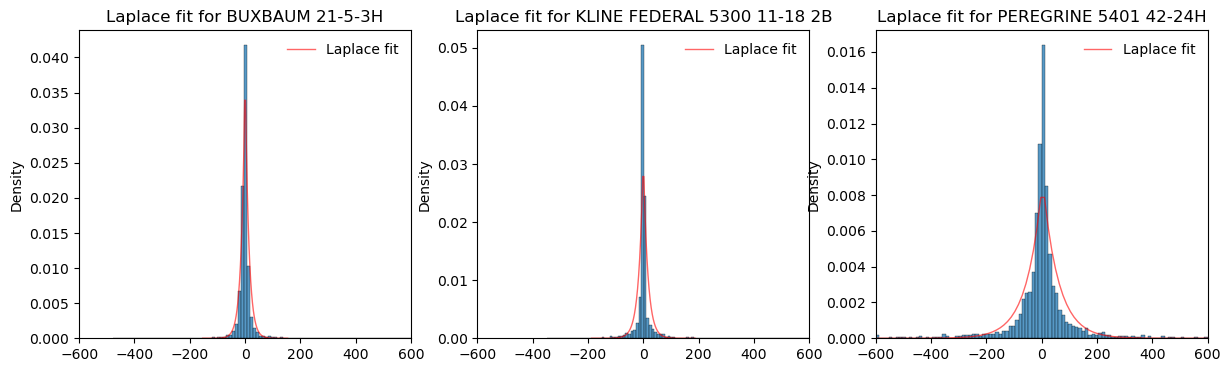

,WELL_NAME,LOC,SCALE,LOG_LIKELIHOOD,KS_STAT,KS_STAT_PVAL
0,BUXBAUM 21-5-3H,0.024445,13.101288,-13236.956613,0.090926,8.956336e-23
1,KLINE FEDERAL 5300 11-18 2B,-0.445738,15.944724,-12298.030324,0.158102,1.219594e-60
2,PEREGRINE 5401 42-24H,3.062090,56.414814,-10043.191698,0.096087,1.513187e-14


In [32]:
# test goodness of fit of a laplace error distribution
distribution = laplace

fig, axs = plt.subplots(ncols=3, figsize=(3 * 3 * golden_ratio, 4))
laplace_dist = pd.DataFrame(np.zeros([3,6]), columns=['WELL_NAME', 'LOC', 'SCALE', 'LOG_LIKELIHOOD', 'KS_STAT', 'KS_STAT_PVAL'])
for i, well in enumerate(prod['WELL_NAME'].unique()):
    data = np.clip(arima_models[well].resid, -600, 600)
    fit = distribution.fit(data)
    loc, scale = fit[0], fit[1]
    log_likelihood = distribution.logpdf(data, loc=loc, scale=scale).sum()
    ks_stat, ks_stat_pval = kstest(data, 'laplace', args=(loc, scale))
    laplace_dist.loc[i] = [well, loc, scale, log_likelihood, ks_stat, ks_stat_pval]

    sns.histplot(data, ax=axs[i], stat='density', bins=100)
    x = np.linspace(distribution.ppf(0.01, loc, scale * 3), distribution.ppf(0.99, loc, scale * 3), 100)
    axs[i].plot(x, distribution.pdf(x, loc, scale), 'r-', lw=1, alpha=0.6, label='Laplace fit')
    axs[i].set(title='Laplace fit for ' + well, xlim=(-600,600))
    axs[i].legend(loc='best', frameon=False)
plt.show()
laplace_dist.head(5)


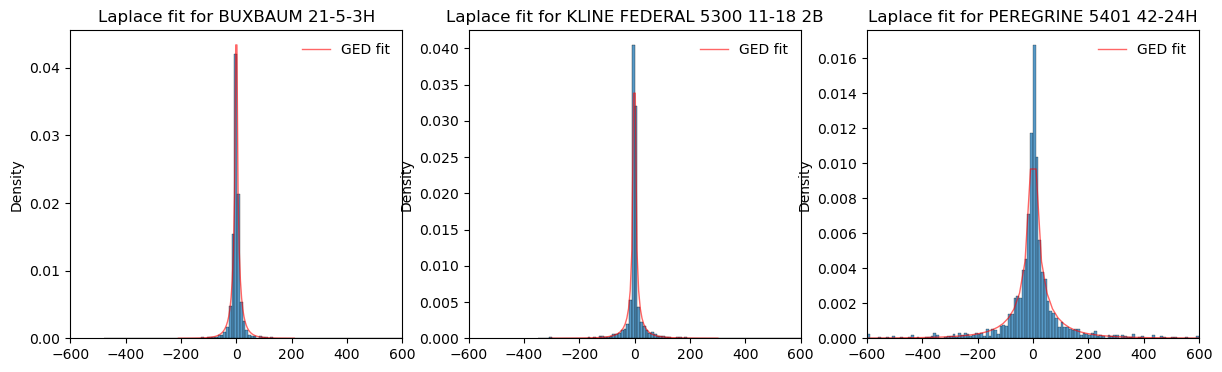

,WELL_NAME,BETA,LOC,SCALE,LOG_LIKELIHOOD,KS_STAT,KS_STAT_PVAL
0,BUXBAUM 21-5-3H,0.517062,0.307918,2.396137,-12828.168026,0.038524,0.000194
1,KLINE FEDERAL 5300 11-18 2B,0.342161,-0.518026,0.290693,-11245.706194,0.039554,0.000349
2,PEREGRINE 5401 42-24H,0.471370,1.395885,7.197325,-9820.149280,0.038481,0.010799


In [33]:
# test goodness of fit of a gennorm error distribution
distribution = gennorm

fig, axs = plt.subplots(ncols=3, figsize=(3 * 3 * golden_ratio, 4))
laplace_dist = pd.DataFrame(np.zeros([3,7]), columns=['WELL_NAME', 'BETA', 'LOC', 'SCALE', 'LOG_LIKELIHOOD', 'KS_STAT', 'KS_STAT_PVAL'])
for i, well in enumerate(prod['WELL_NAME'].unique()):
    data = data = np.clip(arima_models[well].resid, -600, 600)
    fit = distribution.fit(data)
    beta, loc, scale = fit[0], fit[1], fit[2]
    log_likelihood = distribution.logpdf(data, beta=beta, loc=loc, scale=scale).sum()
    ks_stat, ks_stat_pval = kstest(data, 'gennorm', args=(beta, loc, scale))
    laplace_dist.loc[i] = [well, beta, loc, scale, log_likelihood, ks_stat, ks_stat_pval]

    sns.histplot(data, ax=axs[i], stat='density', binwidth=10)
    x = np.linspace(distribution.ppf(0.01, beta, loc, scale * 3), distribution.ppf(0.99, beta, loc, scale * 3), 100)
    axs[i].plot(x, distribution.pdf(x, beta, loc, scale), 'r-', lw=1, alpha=0.6, label='GED fit')
    axs[i].set(title='Laplace fit for ' + well, xlim=(-600,600))
    axs[i].legend(loc='best', frameon=False)
plt.show()
laplace_dist.head(5)

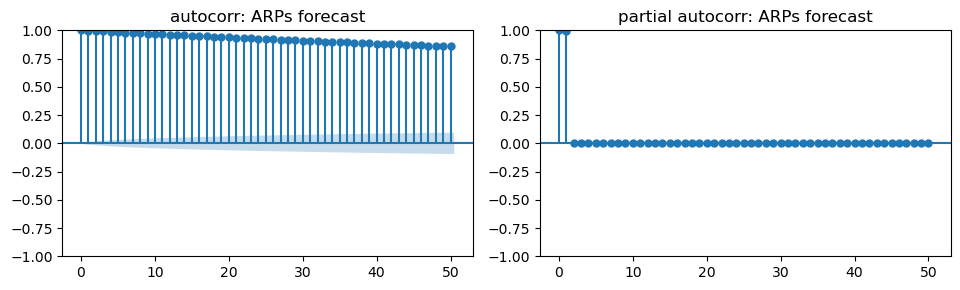

In [34]:
# build the model and view summaries
arps = calc_modified_arps(qi=3000, di=0.7, b=1.001, dmin=0.07, qab=1)

fig, axs = plt.subplots(ncols=2, figsize=(2 * 3 * golden_ratio, 3))
ax = axs[0]
plot_acf(arps, ax=ax, lags=50)
ax.set(title='autocorr: ARPs forecast')
ax = axs[1]
plot_pacf(arps, ax=ax, lags=50)
ax.set(title='partial autocorr: ARPs forecast')
plt.tight_layout(); plt.show()

/Users/home/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                36500
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -39827.409
Date:                Sun, 28 Jan 2024   AIC                          79662.818
Time:                        13:24:53   BIC                          79696.839
Sample:                             0   HQIC                         79673.633
                              - 36500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        208.1795   1.26e-09   1.65e+11      0.000     208.179     208.179
x1            -0.0821      0.009     -8.761      0.000      -0.100      -0.064
ar.L1          1.0000   5.57e-07   1.79e+06      0.0

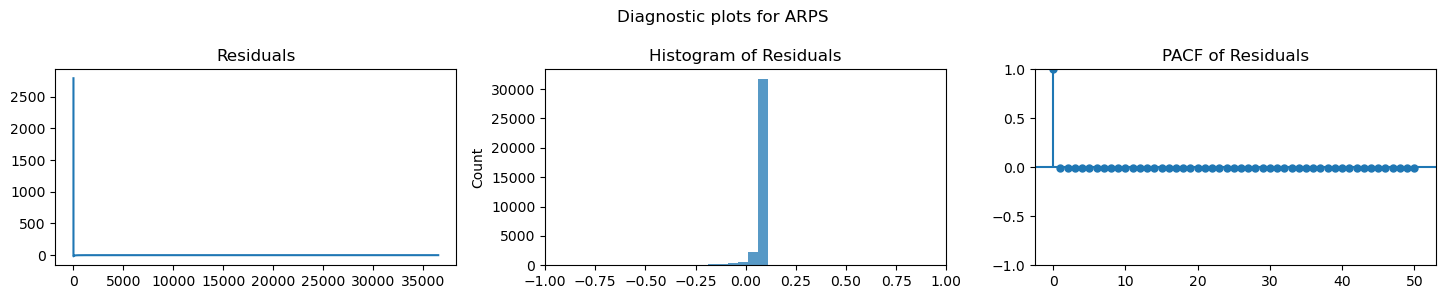

(None, None)

In [35]:
arima_models['ARPS'] = ARIMA(arps, order=(1, 0, 0), trend='ct').fit()  # AR(1) model
print(arima_models['ARPS'].summary())

fig, axs = plt.subplots(ncols=3,figsize=(3 * 3 * golden_ratio, 3))
axs[0].plot(arima_models['ARPS'].resid)
axs[0].set_title('Residuals')
sns.histplot(arima_models['ARPS'].resid, ax=axs[1], binwidth=0.05)
axs[1].set(title='Histogram of Residuals', xlim=(-1,1))
plot_pacf(arima_models['ARPS'].resid, lags=50, ax=axs[2])
axs[2].set_title('PACF of Residuals')
fig.suptitle('Diagnostic plots for ARPS')
plt.tight_layout(), plt.show()

# INVESTIGATE THE DAILY PERCENTAGE CHANGE

/var/folders/s9/_cs16tjx7cx0fn7dssgglhbh0000gn/T/ipykernel_9959/1277402728.py:2: RuntimeWarning: invalid value encountered in divide
  arps_pct_change = np.diff(arps) / arps[:-1] * 100


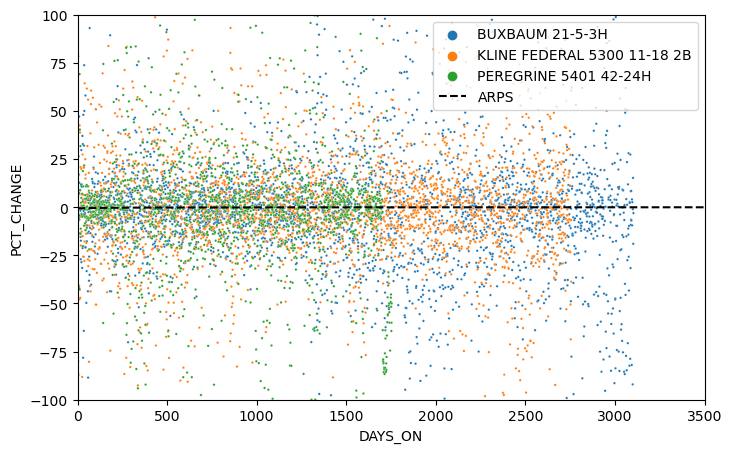

In [44]:
# plot the pct change profile for each well
arps_pct_change = np.diff(arps) / arps[:-1] * 100

fig, ax = plt.subplots(figsize=(5 * golden_ratio, 5))
sns.scatterplot(x='DAYS_ON', y='PCT_CHANGE', hue='WELL_NAME', data=prod, ax=ax, s=3)
ax.plot(range(0, len(arps_pct_change)), arps_pct_change, color='black', linestyle='--', label='ARPS')
ax.set(ylim=(-100,100), xlim=(0,3500))
ax.legend(loc='best', frameon=True)
plt.show()

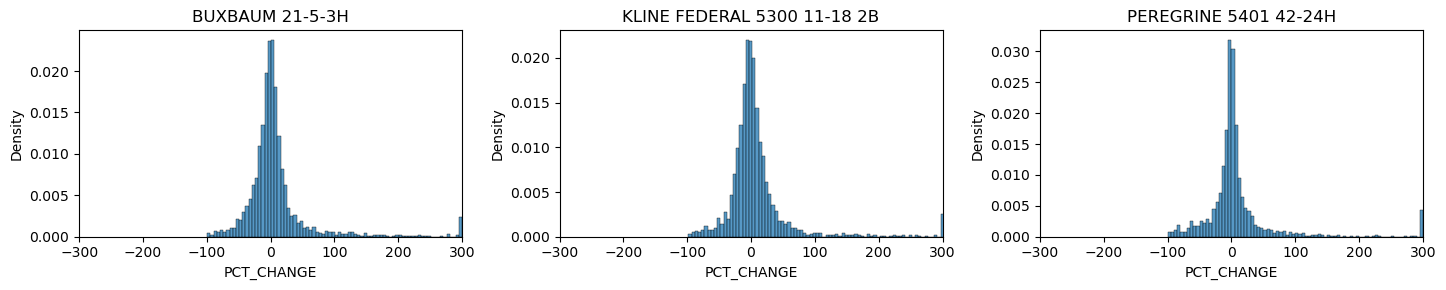

In [46]:
fig, axs = plt.subplots(ncols=3, figsize=(3 * 3 * golden_ratio, 3))
for i, well in enumerate(prod['WELL_NAME'].unique()):
    data = np.clip(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['PCT_CHANGE'].dropna(), -300, 300)
    sns.histplot(data, ax=axs[i], stat='density', binwidth=5)
    axs[i].set(title=well, xlim=(-300,300))
plt.tight_layout(); plt.show()

In [47]:
# create a table of the skew and kurtois for each well
resid_dist = pd.DataFrame(np.zeros([3,6]), columns=['WELL_NAME', 'MEAN', 'MEDIAN', 'STD', 'SKEW', 'KURT'])
for i, well in enumerate(prod['WELL_NAME'].unique()):
    data = np.clip(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['PCT_CHANGE'].dropna(), -300, 300)
    mean = np.mean(data)
    median = np.median(data)
    std = np.std(data)
    skew = robust_skewness(data)[1]
    kurt = robust_kurtosis(data)[1]
    resid_dist.loc[i] = [well, mean, median, std, skew, kurt]
resid_dist.head(5)

,WELL_NAME,MEAN,MEDIAN,STD,SKEW,KURT
0,BUXBAUM 21-5-3H,8.256023,0.127985,52.953534,-0.014455,0.650045
1,KLINE FEDERAL 5300 11-18 2B,7.656245,-0.218387,50.748345,0.078215,0.432061
2,PEREGRINE 5401 42-24H,8.155782,0.000000,58.288590,-0.013782,1.249943


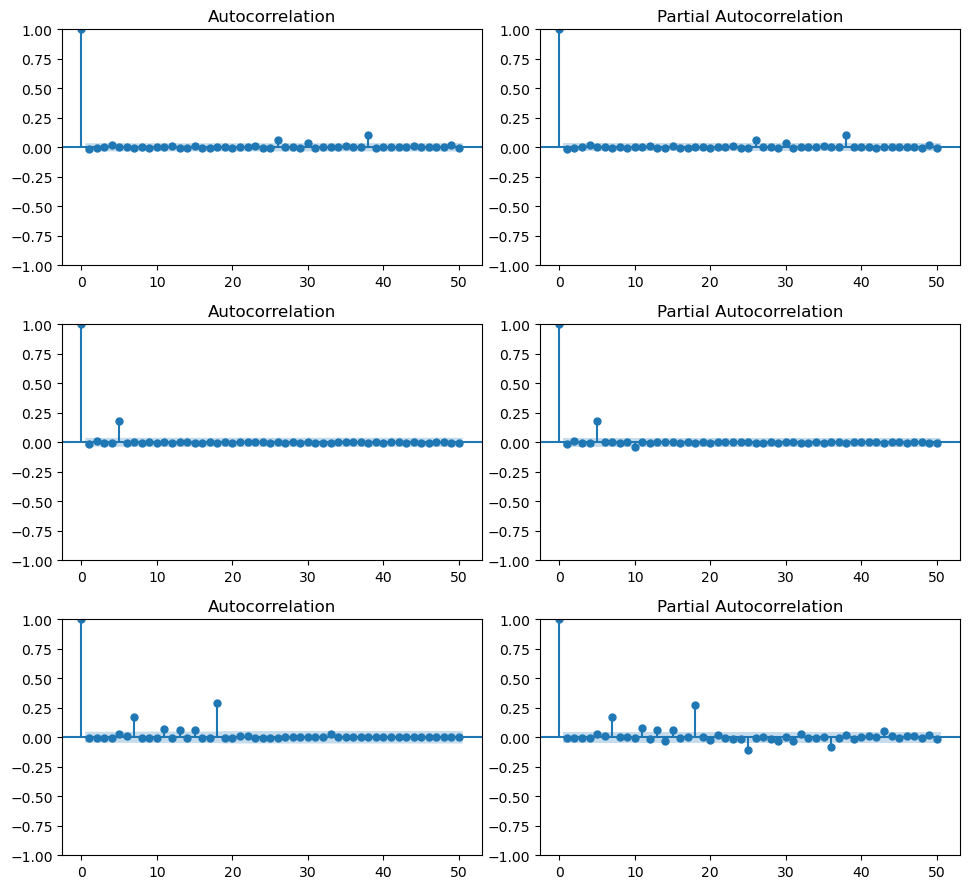

In [39]:
# plot the autcorr and partial autocorr for each well
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(2 * 3 * golden_ratio, 3 * 3))
for i, well in enumerate(prod['WELL_NAME'].unique()):
    plot_acf(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['PCT_CHANGE'].dropna(), ax=axs[i,0], lags=50)
    ax.set(title='autocorr: ' + well, xlabel='Lags')
    plot_pacf(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['PCT_CHANGE'].dropna(), ax=axs[i,1], lags=50)
    ax.set(title='partial autocorr: ' + well, xlabel='Lags')
plt.tight_layout(); plt.show()

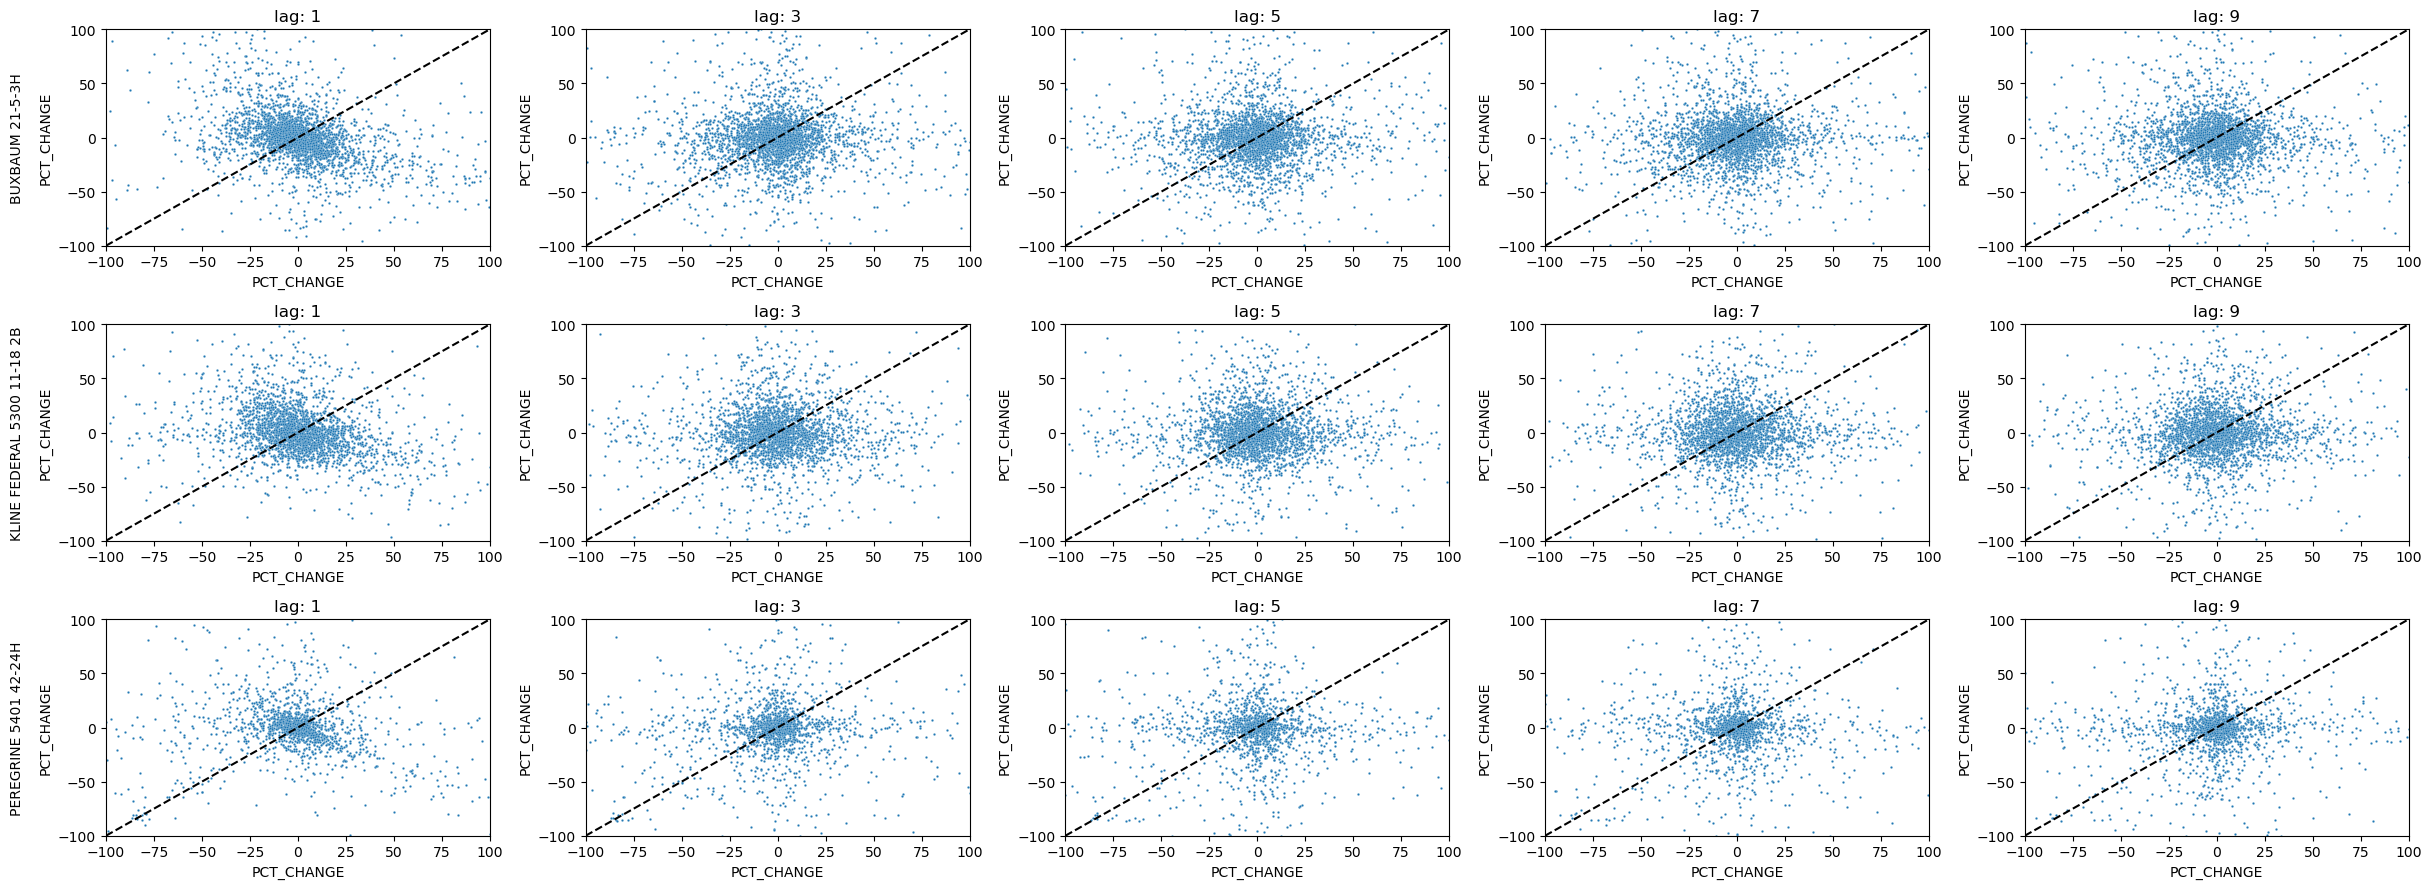

In [50]:
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(5 * 3 * golden_ratio, 3 * 3))
for i, well in enumerate(prod['WELL_NAME'].unique()):
    for j, lag in enumerate(range(1,10,2)):
        ax = axs[i, j]
        data = prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['PCT_CHANGE']
        shifted_data = data.shift(lag)
        sns.scatterplot(x=data, y=shifted_data, ax=ax, s=3)
        ax.plot([-100, 100], [-100, 100], color='black', linestyle='--')
        ax.set(xlim=(-100,100), ylim=(-100,100), title='lag: ' + str(lag))
        
    # Add well name as a label on the left side and rotate 180 degrees
    axs[i, 0].text(-0.25, 0.5, well, transform=axs[i, 0].transAxes, va='center', rotation=90)
    
plt.tight_layout(); plt.show()

The daily percentage change in production appears to have no autocorrelation

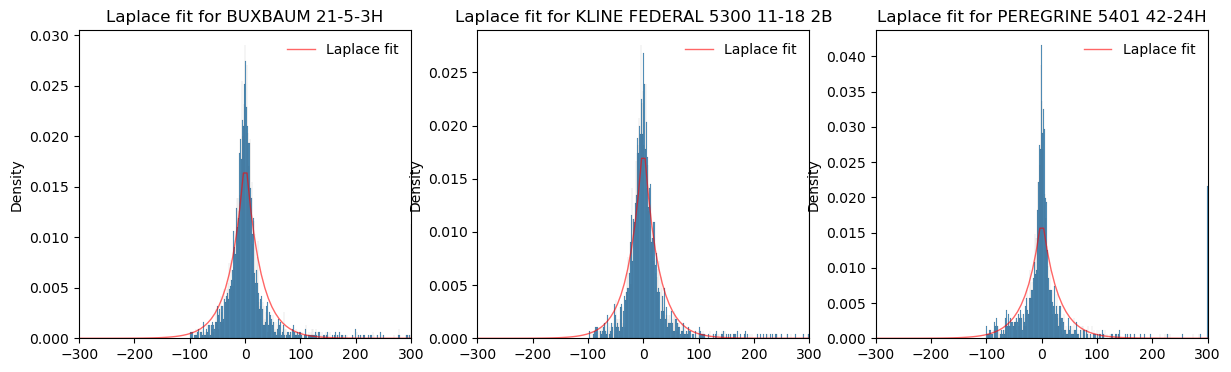

,WELL_NAME,LOC,SCALE,LOG_LIKELIHOOD,KS_STAT,KS_STAT_PVAL
0,BUXBAUM 21-5-3H,0.127985,27.168691,-15495.148926,0.071076,4.516591e-14
1,KLINE FEDERAL 5300 11-18 2B,-0.218387,26.251778,-13672.187747,0.080936,3.757951e-16
2,PEREGRINE 5401 42-24H,0.000000,28.436160,-8841.578531,0.100065,9.661100e-16


In [54]:
# test goodness of fit of a laplace error distribution
distribution = laplace

fig, axs = plt.subplots(ncols=3, figsize=(3 * 3 * golden_ratio, 4))
laplace_dist = pd.DataFrame(np.zeros([3,6]), columns=['WELL_NAME', 'LOC', 'SCALE', 'LOG_LIKELIHOOD', 'KS_STAT', 'KS_STAT_PVAL'])
for i, well in enumerate(prod['WELL_NAME'].unique()):
    data = np.clip(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['PCT_CHANGE'].dropna().values, -300, 300)
    fit = distribution.fit(data)
    loc, scale = fit[0], fit[1]
    log_likelihood = distribution.logpdf(data, loc=loc, scale=scale).sum()
    ks_stat, ks_stat_pval = kstest(data, 'laplace', args=(loc, scale))
    laplace_dist.loc[i] = [well, loc, scale, log_likelihood, ks_stat, ks_stat_pval]

    sns.histplot(data, ax=axs[i], stat='density', binwidth=1)
    x = np.linspace(distribution.ppf(0.01, loc, scale * 3), distribution.ppf(0.99, loc, scale * 3), 100)
    axs[i].plot(x, distribution.pdf(x, loc, scale), 'r-', lw=1, alpha=0.6, label='Laplace fit')
    axs[i].set(title='Laplace fit for ' + well, xlim=(-300,300))
    axs[i].legend(loc='best', frameon=False)
plt.show()
laplace_dist.head(5)

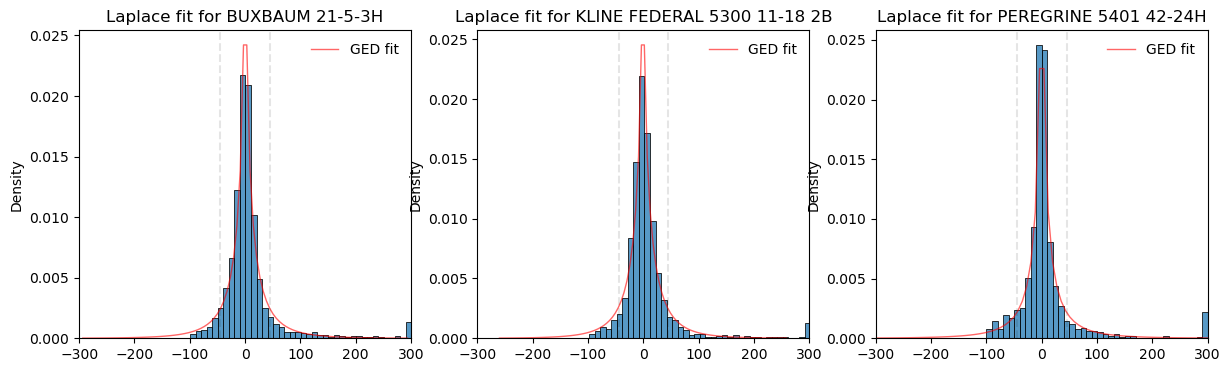

,WELL_NAME,BETA,LOC,SCALE,STD,LOG_LIKELIHOOD,KS_STAT,KS_STAT_PVAL
0,BUXBAUM 21-5-3H,0.535119,3.657912e-02,5.765059,46.606491,-15172.719518,0.037754,2.810151e-04
1,KLINE FEDERAL 5300 11-18 2B,0.586610,-1.014713e+00,7.741276,43.365357,-13457.516887,0.054428,1.547446e-07
2,PEREGRINE 5401 42-24H,0.430398,2.774212e-11,2.281491,54.733542,-8519.243751,0.028615,1.109440e-01


In [66]:
# test goodness of fit of a gennorm error distribution
distribution = gennorm

fig, axs = plt.subplots(ncols=3, figsize=(3 * 3 * golden_ratio, 4))
laplace_dist = pd.DataFrame(np.zeros([3,8]), columns=['WELL_NAME', 'BETA', 'LOC', 'SCALE', 'STD', 
                                                      'LOG_LIKELIHOOD', 'KS_STAT', 'KS_STAT_PVAL'])
for i, well in enumerate(prod['WELL_NAME'].unique()):
    data = np.clip(prod.loc[(prod['WELL_NAME'] == well) & (prod['ON'])]['PCT_CHANGE'].dropna().values, -300, 300)
    fit = distribution.fit(data)
    beta, loc, scale = fit[0], fit[1], fit[2]
    scale_std = scale * np.sqrt(120)
    std = np.sqrt(distribution.var(beta, loc, scale))
    log_likelihood = distribution.logpdf(data, beta=beta, loc=loc, scale=scale).sum()
    ks_stat, ks_stat_pval = kstest(data, 'gennorm', args=(beta, loc, scale))
    laplace_dist.loc[i] = [well, beta, loc, scale, std, log_likelihood, ks_stat, ks_stat_pval]

    sns.histplot(data, ax=axs[i], stat='density', binwidth=10)
    x = np.linspace(distribution.ppf(0.001, beta, loc, scale), distribution.ppf(0.999, beta, loc, scale), 100)
    axs[i].plot(x, distribution.pdf(x, beta, loc, scale), 'r-', lw=1, alpha=0.6, label='GED fit')
    axs[i].axvline(45, color='black', linestyle='--', alpha=0.1)
    axs[i].axvline(-45, color='black', linestyle='--', alpha=0.1)
    axs[i].set(title='Laplace fit for ' + well, xlim=(-300,300))
    axs[i].legend(loc='best', frameon=False)
plt.show()
laplace_dist.head(5)

In [43]:
gennorm.rvs(beta=0.5, loc=0, scale=0.05, size=10)

array([ 4.40538091e-04,  1.97583659e-01, -3.93595362e-01, -1.89714632e-02,
       -1.63973586e-01,  3.41873861e-01,  4.66462583e-01, -2.24604065e-01,
       -8.22510511e-02,  8.73599612e-02])

**A general normal error distribution is clearly the closest fit**
- beta = 0.5
- loc = 0
- scale = 0.05 